In [1]:
import cv2
import warnings
import numpy as np
import matplotlib.pyplot as plt

### 数据导入 

In [2]:
import os
dirname = os.path.dirname('/home/mullin/WorkSpace/CourseProject/3 VAMR/Exercise 5 - Stereo Dense Reconstruction/')

In [3]:
# Scaling down by a factor of 2, otherwise too slow.
left_img = cv2.resize(cv2.imread(dirname + '/data/left/000000.png', cv2.IMREAD_GRAYSCALE), None,
                      fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR)
right_img = cv2.resize(cv2.imread(dirname + '/data/right/000000.png', cv2.IMREAD_GRAYSCALE), None,
                       fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR)
K = np.loadtxt(dirname + '/data/K.txt')
K[0:2, :] /= 2
poses = np.loadtxt(dirname + '/data/poses.txt')

####  Parameters Show

In [4]:
poses

array([[ 1.000000e+00,  9.043680e-12,  2.326809e-11, ...,  2.392370e-10,
         9.999999e-01, -4.440892e-16],
       [ 9.999978e-01,  5.272628e-04, -2.066935e-03, ...,  1.155958e-03,
         9.999971e-01,  8.586941e-01],
       [ 9.999910e-01,  1.048972e-03, -4.131348e-03, ...,  2.312456e-03,
         9.999887e-01,  1.716275e+00],
       ...,
       [ 9.982814e-01,  1.472502e-02,  5.672377e-02, ...,  7.035887e-03,
         9.983589e-01,  8.300846e+01],
       [ 9.959138e-01,  1.420072e-02,  8.918593e-02, ...,  5.307184e-03,
         9.959934e-01,  8.345454e+01],
       [ 9.920007e-01,  1.389449e-02,  1.254661e-01, ...,  4.279320e-03,
         9.920798e-01,  8.388530e+01]])

In [ ]:
K

<function matplotlib.pyplot.show(close=None, block=None)>

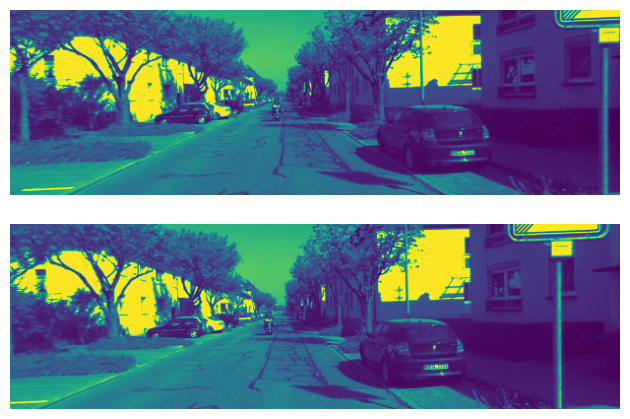

In [5]:
plt.figure()
plt.subplot(2,1,1)
plt.imshow(left_img)
plt.axis('off')
plt.tight_layout()
plt.subplot(2,1,2)
plt.imshow(right_img)
plt.axis('off')
plt.tight_layout()
plt.show

In [6]:
# Given by the KITTI dataset:
baseline = 0.54

# Carefully tuned by the TAs:
patch_radius = 5
min_disp = 5
max_disp = 50
xlims = [7, 20]
ylims = [-6, 10]
zlims = [-5, 5]

### 获取disparity

In [7]:
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist


def getDisparity(left_img, right_img, patch_radius, min_disp, max_disp):
    """
    left_img and right_img are both H x W and you should return a H x W matrix containing the disparity d for
    each pixel of left_img. Set disp_img to 0 for pixels where the SSD and/or d is not defined, and for
    d estimates rejected in Part 2. patch_radius specifies the SSD patch and each valid d should satisfy
    min_disp <= d <= max_disp.
    """
    r_p = patch_radius
    patch_size = 2 * r_p + 1
    img_dis = np.zeros(left_img.shape).astype(np.float)
    n_row, n_col = left_img.shape
    for row in range (r_p, n_row - r_p):
        for col in range (max_disp + r_p, n_col - r_p): # p1 = p0 -d
            left_patch = left_img[(row-r_p):(row+r_p+1), (col-r_p):(col+r_p+1)]
            right_strip = right_img[(row-r_p):(row+r_p+1),(col-r_p-max_disp):(col+r_p-min_disp+1)] 

            right_patches  = np.zeros([patch_size, patch_size, max_disp - min_disp + 1])
            for i in range (0, max_disp - min_disp + 1):
                right_patches[:, :, i] = right_strip[:, i:i+2*r_p+1]

            leftP_vec =  left_patch.flatten()
            rightPs_vecs = right_patches.reshape([patch_size**2,  max_disp - min_disp +1])
            ssds = cdist(leftP_vec[None, :], rightPs_vecs.T, 'sqeuclidean').squeeze(0)

            num_dis = np.argmin(ssds)
            min_ssd = ssds[num_dis]
            outlier_rej = True
            Refine = True

            if outlier_rej:
                if ((ssds <= 1.5 * min_ssd).sum() < 3) and (num_dis != 0) and (num_dis != max_disp - min_disp):
                    if Refine: 
                        x = np.asarray([num_dis - 1, num_dis, num_dis + 1])
                        p = np.polyfit(x, ssds[x], 2)
                        img_dis[row, col] = max_disp + p[1] / (2 * p[0]) - 1
                    else:
                        img_dis[row,col] = float(-(num_dis - max_disp + 1))
            else:
                img_dis[row,col] = -(num_dis - max_disp + 1)    
                
    return img_dis

/tmp/ipykernel_26570/34927531.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img_dis = np.zeros(left_img.shape).astype(np.float)


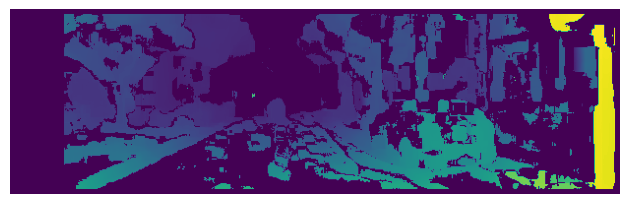

In [8]:

# Parts 1, 2 and 4: Disparity on one image pair
disp_img = getDisparity(left_img, right_img, patch_radius, min_disp, max_disp)

plt.clf()
plt.close()
plt.imshow(disp_img)
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
disp_img  # 四周为0值，中间值不为0

###  Test of solution

In [ ]:
    h, w = disp_img.shape
    # Convenient way to build per-pixel coordinates.
    X, Y = np.meshgrid(np.arange(1, w + 1), np.arange(1, h + 1))
    X, Y = X.reshape(h*w), Y.reshape(h*w)
    px_left = np.stack([X, Y, np.ones_like(X)], axis=-1).astype(np.float)


In [ ]:
h

In [ ]:
w

In [ ]:
X, Y = np.meshgrid(np.arange(1, w + 1), np.arange(1, h + 1))

In [ ]:
X

In [ ]:
Y

In [ ]:
X, Y = X.reshape(h*w), Y.reshape(h*w)

In [ ]:
X

In [ ]:
Y

In [ ]:
px_left
# px_left x:(1->620), y:(1->188), z:1

In [ ]:
    # Corresponding pixels in right image = pixel coords in left img minus disparity.
    px_right = px_left.copy()
    px_right[:, 0] -= disp_img.reshape(h*w)  # 减去位移，即右侧对应像素点

In [ ]:
disp_img

In [ ]:
disp_img.reshape(h*w)

In [ ]:
px_right
# px_left x:(1->620), y:(1->188), z:1

In [ ]:
116560/620

In [ ]:
invalid_disp = disp_img.reshape(h*w) > 0 # 取有明确对应点的

In [ ]:
invalid_disp

In [ ]:
    px_left = px_left[invalid_disp, :]
    px_right = px_right[invalid_disp, :]  # 对应点的左右像素获取

In [ ]:
px_left.shape

In [ ]:
intensities = left_img[invalid_disp.reshape([h, w])]

In [ ]:
intensities.shape

In [ ]:
    K_inv = np.linalg.inv(K)
    bv_left = np.matmul(K_inv, px_left[:, :, None]).squeeze(-1)
    bv_right = np.matmul(K_inv, px_right[:, :, None]).squeeze(-1)


In [ ]:
    # Intersect rays according to formula in problem statement.
    b = np.asarray([baseline, 0, 0])

    A = np.stack([bv_left, -bv_right], axis=-1)
    A_pseudo_inv = np.linalg.inv(np.matmul(A.transpose([0, 2, 1]), A))
    lambda_variable = np.matmul(A_pseudo_inv, np.matmul(A.transpose([0, 2, 1]), b[:, None]))

    points = bv_left * lambda_variable[:, 0, :]


In [ ]:
A

In [ ]:
lambda_variable

In [ ]:
lambda_variable.shape

In [ ]:
A_pinv = np.linalg.pinv(A)

In [ ]:
A_pinv

In [ ]:
lam = np.matmul(A_pinv, b[:, None])

In [ ]:
lam

In [ ]:
lambda_variable[:, 0, :].shape

### Test

In [ ]:
n_rows, n_cols = disp_img.shape

In [ ]:
n_rows

In [ ]:
X,Y = np.meshgrid(np.arange(1, n_cols+1), np.arange(1, n_rows+1))

In [ ]:
    X = X.reshape(n_cols * n_rows)
    Y = Y.reshape(n_cols * n_rows)

In [ ]:
X.shape

In [ ]:
    left_pix = np.stack([X, Y, np.ones_like(X)], axis = 1).astype(np.float)
    right_pix = left_pix.copy()

In [ ]:
left_pix[:,0]

In [ ]:
px_left[:,0]

In [ ]:
    l_pix = np.stack([X, Y, np.ones_like(X)], axis = 1).astype(np.float)
    r_pix = l_pix.copy()
    r_pix[:,0] -= disp_img.reshape(n_rows * n_cols)
    
    disp_flag = disp_img.reshape(n_rows * n_cols) > 0
    l_pix = l_pix[disp_flag,:]
    r_pix = r_pix[disp_flag,:]
    
    intensities = left_img[disp_flag.reshape([n_rows, n_cols])]
 

In [ ]:
r_pix.shape

In [ ]:
intensities

In [ ]:
K_inv = np.linalg.inv(K)

In [ ]:
K_inv

In [ ]:
    K_inv = np.linalg.inv(K)
    
    A_left = np.matmul(K_inv, l_pix[:,:,None]).squeeze(-1)
    A_right = np.matmul(K_inv, r_pix[:,:,None]).squeeze(-1)
    
    b = np.asarray([baseline, 0, 0])
    
    A = np.stack([A_left, -A_right], axis = -1)
    A_pinv = np.linalg.pinv(A)
    lambd = np.matmul(A_pinv, b[:, None])
    
    points = A_left * lambd[:, 0, :]

### Function 

In [9]:
import numpy as np


def disparityToPointCloud(disp_img, K, baseline, left_img):
    """
    points should be Nx3 and intensities N, where N is the amount of pixels which have a valid disparity.
    I.e., only return points and intensities for pixels of left_img which have a valid disparity estimate!
    The i-th intensity should correspond to the i-th point.
    """

    n_rows, n_cols = disp_img.shape
    X,Y = np.meshgrid(np.arange(1, n_cols+1), np.arange(1, n_rows+1))
    X = X.reshape(n_cols * n_rows)
    Y = Y.reshape(n_cols * n_rows)
    
    l_pix = np.stack([X, Y, np.ones_like(X)], axis = 1).astype(np.float)
    r_pix = l_pix.copy()
    r_pix[:,0] -= disp_img.reshape(n_rows * n_cols)
    
    disp_flag = disp_img.reshape(n_rows * n_cols) > 0
    l_pix = l_pix[disp_flag,:]
    r_pix = r_pix[disp_flag,:]
    
    intensities = left_img[disp_flag.reshape([n_rows, n_cols])]
    
    K_inv = np.linalg.inv(K)
    
    A_left = np.matmul(K_inv, l_pix[:,:,None]).squeeze(-1)
    A_right = np.matmul(K_inv, r_pix[:,:,None]).squeeze(-1)
    
    b = np.asarray([baseline, 0, 0])
    
    A = np.stack([A_left, -A_right], axis = -1)
    A_pinv = np.linalg.pinv(A)
    lambd = np.matmul(A_pinv, b[:, None])
    
    points = A_left * lambd[:, 0, :]

    return points, intensities


### 目标代码段

In [10]:
p_C_points, intensities = disparityToPointCloud(disp_img, K, baseline, left_img)
T_C_F = np.asarray([[0, -1, 0],
                    [0, 0, -1],
                    [1, 0, 0]])
p_F_points = np.matmul(np.linalg.inv(T_C_F), p_C_points[::11, :, None]).squeeze(-1)
intensities = intensities[::11]
intensities = np.tile(intensities[:, None], (1, 3)) / 255

/tmp/ipykernel_26570/3609317586.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  l_pix = np.stack([X, Y, np.ones_like(X)], axis = 1).astype(np.float)


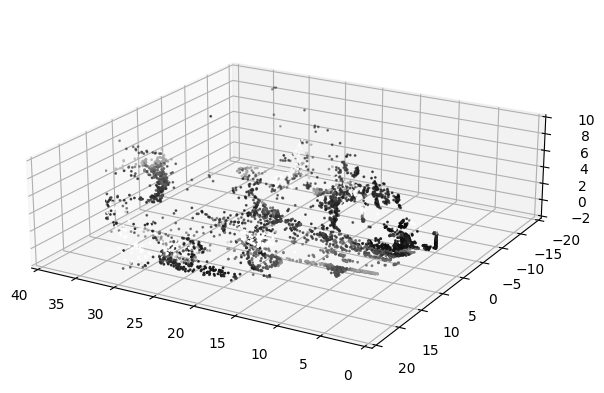

In [11]:
plt.clf()
plt.close()
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(p_F_points[:, 0], p_F_points[:, 1], p_F_points[:, 2], s=1, c=intensities)
ax.set_box_aspect((1, 1, 12/40))

ax.azim = 120
ax.dist = 7
ax.elev = 20

ax.axes.set_xlim3d(left=0, right=40)
ax.axes.set_ylim3d(bottom=-20, top=20)
ax.axes.set_zlim3d(bottom=-2, top=10)

plt.show()

### solution

In [ ]:
import numpy as np


def disparityToPointCloud_solution(disp_img, K, baseline, left_img):
    """
    points should be Nx3 and intensities N, where N is the amount of pixels which have a valid disparity.
    I.e., only return points and intensities for pixels of left_img which have a valid disparity estimate!
    The i-th intensity should correspond to the i-th point.
    """
    h, w = disp_img.shape
    # Convenient way to build per-pixel coordinates.
    X, Y = np.meshgrid(np.arange(1, w + 1), np.arange(1, h + 1))
    X, Y = X.reshape(h*w), Y.reshape(h*w)
    px_left = np.stack([X, Y, np.ones_like(X)], axis=-1).astype(np.float)

    # Corresponding pixels in right image = pixel coords in left img minus disparity.
    px_right = px_left.copy()
    px_right[:, 0] -= disp_img.reshape(h*w)
    
    # Filter out pixels that do not have a known disparity.
    invalid_disp = disp_img.reshape(h*w) > 0
    px_left = px_left[invalid_disp, :]
    px_right = px_right[invalid_disp, :]
    intensities = left_img[invalid_disp.reshape([h, w])]
    
    # Reproject pixels: Get bearing vectors of rays in camera frame.
    K_inv = np.linalg.inv(K)
    bv_left = np.matmul(K_inv, px_left[:, :, None]).squeeze(-1)
    bv_right = np.matmul(K_inv, px_right[:, :, None]).squeeze(-1)

    # Intersect rays according to formula in problem statement.
    b = np.asarray([baseline, 0, 0])

    A = np.stack([bv_left, -bv_right], axis=-1)
    A_pseudo_inv = np.linalg.inv(np.matmul(A.transpose([0, 2, 1]), A))
    lambda_variable = np.matmul(A_pseudo_inv, np.matmul(A.transpose([0, 2, 1]), b[:, None]))

    points = bv_left * lambda_variable[:, 0, :]


    return points, intensities


In [ ]:
p_C_points, intensities = disparityToPointCloud_solution(disp_img, K, baseline, left_img)
T_C_F = np.asarray([[0, -1, 0],
                    [0, 0, -1],
                    [1, 0, 0]])
p_F_points = np.matmul(np.linalg.inv(T_C_F), p_C_points[::11, :, None]).squeeze(-1)
intensities = intensities[::11]
intensities = np.tile(intensities[:, None], (1, 3)) / 255

plt.clf()
plt.close()
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(p_F_points[:, 0], p_F_points[:, 1], p_F_points[:, 2], s=1, c=intensities)
ax.set_box_aspect((1, 1, 12/40))

ax.azim = 120
ax.dist = 7
ax.elev = 20

ax.axes.set_xlim3d(left=0, right=40)
ax.axes.set_ylim3d(bottom=-20, top=20)
ax.axes.set_zlim3d(bottom=-2, top=10)

plt.show()

In [ ]:
intensities

In [ ]:
p_F_points

In [ ]:
p_C_points[::11]